In [1]:
# General
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint

# ML
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb 

# Custom
import sys,os
sys.path.append( '.' )
sys.path.append( '..' )
import Components.data_fetching as data_fetching
import Components.feature_extraction as feature_extraction
import Components.Classifying_Transformer as clt
import Components.Smoothing_Classifier as smcl
import Components.Neighbour_Features as nf

# CAREFUL:
# If you make changes to a custom module, you have to reload it, i.e rerun this cell
import importlib
importlib.reload(data_fetching)
importlib.reload(feature_extraction)
importlib.reload(clt)
importlib.reload(smcl)
importlib.reload(nf)

<module 'Components.Neighbour_Features' from '../Components/Neighbour_Features.py'>

# Data Fetching

In [2]:
_, y = data_fetching.get_train_data()
y = np.ravel(y)

In [3]:
X = feature_extraction.get_features(None, precomputed='train')
X_test = feature_extraction.get_features(None, precomputed='test')

In [4]:
# scaling before: 
df_1 = X.iloc[0:21600]
df_2 = X.iloc[21600:43200]
df_3 = X.iloc[43200:64800]

In [5]:
test_1 = X_test.iloc[0:21600]
test_2 = X_test.iloc[21600:43200]

In [6]:
scaler = StandardScaler()
df_1 = scaler.fit_transform(df_1)
df_2 = scaler.fit_transform(df_2)
df_3 = scaler.fit_transform(df_3)


In [7]:
df_1 = pd.DataFrame(df_1)
df_2 = pd.DataFrame(df_2)
df_3 = pd.DataFrame(df_3)

In [8]:
X = pd.concat([df_1, df_2, df_3])

In [9]:
scaler = StandardScaler()
test_1 = scaler.fit_transform(test_1)
test_2 = scaler.fit_transform(test_2)

In [10]:
test_1 = pd.DataFrame(test_1)
test_2 = pd.DataFrame(test_2)

In [11]:
X_test = pd.concat([test_1, test_2])

In [12]:
print(X_test)

            0         1         2         3         4         5         6    \
0      0.894242  1.187088  0.305553  0.052411 -0.066487  0.510407 -0.905370   
1      1.055782  1.030386  0.343506  0.052411  0.081308  0.581330  0.132895   
2      1.206216  1.442781  0.488248  0.323371  0.081308  0.680623 -0.334730   
3      0.851291  0.720882  0.391245  0.323371  0.081308  0.524592 -0.707474   
4      0.976228  0.921660  0.269594 -0.218550 -0.214283  0.836654 -0.462930   
...         ...       ...       ...       ...       ...       ...       ...   
21595  0.912310  1.057562 -0.492466  0.316992  0.174128  0.002488 -0.876965   
21596  0.923072  1.045693 -1.084291  0.034867  0.174128  0.090663 -0.583753   
21597  0.963929  1.003551 -0.181838 -0.106195  0.588956  0.355187 -0.708135   
21598  0.963929  1.003551 -0.181838 -0.106195  0.588956  0.355187 -0.708135   
21599  0.963929  1.003551 -0.181838 -0.106195  0.588956  0.355187 -0.708135   

            7         8         9    ...       173 

# Cross-validation

In [15]:
pipe = Pipeline([('PCA', PCA(n_components=90)),
                 ('neighbour_features', nf.Neighbour_Features(lag=10)),
                 ('classification',lgb.LGBMClassifier(class_weight = 'balanced'))])

In [22]:
# Train on 2 subjects, test on the other
n_epochs = 21600
splits = [(np.r_[0:2*n_epochs], np.r_[2*n_epochs:3*n_epochs]),
 (np.r_[0:n_epochs, 2*n_epochs:3*n_epochs], np.r_[n_epochs:2*n_epochs]),
 (np.r_[n_epochs:3*n_epochs], np.r_[0:n_epochs])]

# format: 
# [(train_indices, test_indices),
#    (train_indices, test_indices),....]

cv_score = cross_val_score(pipe, X, y, cv=3, scoring='balanced_accuracy',n_jobs=15)
print(cv_score)
print(f"mean: {np.mean(cv_score)}")
print(f"standard deviation: {np.std(cv_score)}")

#LGB all MNE features
#[0.70943547 0.95720017 0.88320811]
#0.8499479178461647
# standard deviation 0.10384769933882516

# both steps LGB, lag 5, border-vote 5
#[0.5997921  0.95668261 0.8793381 ]
#0.8119376038984457

# both steps LGB, lag 10, border-vote 5
#[0.60192032 0.95705123 0.87927879]
#0.8127501105221282
#standard deviation 0.15242274419875892

# both steps LGB, lag 100, border-vote 5
#[0.60703004 0.95650736 0.8793381 ]
#0.814291835327246

# both steps LGB, lag 200, border-vote 5
#[0.5985031  0.95719145 0.87924913]
#0.8116478914896422

# PCA 90 features of neighbors with lag 2, LGB
#[0.88570544 0.96200852 0.88843848]
#0.9120508105283455
# standard deviation 0.03534304946713885

# PCA 90 features of neighbors with lag 5, LGB
#[0.88625419 0.96170667 0.88667096]
#0.9115439404692363
# standard deviation 0.03547081172345031

# PCA 90 features of neighbors with lag 3, LGB
#[0.861241   0.96152223 0.89151204]
#mean: 0.9047584237384917
#standard deviation: 0.04199747226951646

# PCA 90 features of neighbors with lag 10, LGB
#[0.89934699 0.95969502 0.89153696]
#mean: 0.9168596564263747
#standard deviation: 0.0304565305043997

# PCA 183 features of neighbors with lag 2, LGB
#[0.88929445 0.9606122  0.89447762]
#mean: 0.9147947558993065
#standard deviation: 0.032466852580241304

#### per subject scaling #####

# PCA 183 features of neighbors with lag 2, LGB
#[0.95735679 0.9524802  0.87103495]
#mean: 0.926957314181267
#standard deviation: 0.03959316651788484

# PCA 90 features of neighbors with lag 10, LGB
# [0.96243584 0.95942133 0.87194826]
# mean: 0.9312684771525119
# standard deviation: 0.04196378080611828

[0.90740425 0.96832406 0.96189394]
mean: 0.9458740823727844
standard deviation: 0.02732864831541495


# Prediction

In [34]:
pipe = Pipeline([('PCA', PCA(n_components=90)),
                 ('neighbour_features', nf.Neighbour_Features(lag=10)),
                 ('classification',lgb.LGBMClassifier(class_weight = 'balanced'))])

(array([20222.,     0.,     0.,     0.,     0., 20674.,     0.,     0.,
            0.,  2304.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

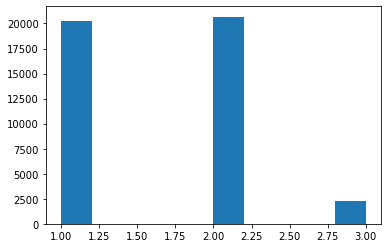

In [35]:
pipe.fit(X,y)
y_pred = pipe.predict(X_test)
plt.hist(y_pred)



In [36]:
print(y_pred)

[1 1 1 ... 1 1 1]


In [37]:
y_pred_pd = pd.DataFrame(data=y_pred, columns=["y"])
y_pred_pd.to_csv('../../Predictions/LGB_MNE_90_Features_10_neighbours_persubj_scaling.csv', index_label='Id')

# Plots

**sleep stages of first subject**

In [5]:
pipe = Pipeline([('scaling',StandardScaler()),
                 ('individual_classification', clt.Classifying_Transformer(lgb.LGBMClassifier(class_weight = 'balanced'))),
                 ('smoothing', smcl.Smoothing_Classifier(lgb.LGBMClassifier(class_weight = 'balanced'), lag= 100, border_vote = 5))])

In [6]:
n_epochs = 21600
X_train_split = X[:2*n_epochs]
y_train_split = y[:2*n_epochs]
pipe.fit(X_train_split, y_train_split)

Pipeline(steps=[('scaling', StandardScaler()),
                ('individual_classification',
                 Classifying_Transformer(clf=LGBMClassifier(class_weight='balanced'))),
                ('smoothing',
                 Smoothing_Classifier(clf=LGBMClassifier(class_weight='balanced'),
                                      lag=100))])

In [7]:
y_train_pred = pipe.predict(X[2*n_epochs:])

In [12]:
X[2*n_epochs:]

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
43200,1.033303,0.920015,1.213831,0.078125,0.078125,0.062500,0.000020,0.000033,0.000045,0.000071,...,-0.540018,1.534146e-16,0.837714,2.162286,-0.267581,-0.679056,-0.525617,4.440892e-16,1.257124,1.742876
43201,1.052345,1.016056,1.202260,0.046875,0.046875,0.070312,0.000007,0.000031,0.000070,0.000092,...,-0.557447,2.718501e-16,0.800382,2.199618,-0.275834,-0.704314,-0.488074,2.220446e-16,1.254318,1.745682
43202,1.100242,1.020074,1.262230,0.078125,0.062500,0.070312,0.000030,0.000028,0.000039,0.000063,...,-0.668729,4.375348e-16,0.624054,2.375946,-0.307308,-0.715366,-0.445100,2.220446e-16,1.266975,1.733025
43203,1.032172,1.003457,1.167331,0.046875,0.039062,0.054688,0.000008,0.000039,0.000072,0.000082,...,-0.538612,4.900594e-17,0.928500,2.071500,-0.245851,-0.683546,-0.539455,0.000000e+00,1.237915,1.762085
43204,1.103244,1.040231,1.319207,0.046875,0.101562,0.062500,0.000009,0.000032,0.000062,0.000072,...,-0.769731,8.474383e-16,0.486642,2.513358,-0.200466,-0.737942,-0.513232,0.000000e+00,1.186706,1.813294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64795,1.263937,1.272850,1.239550,0.070312,0.390625,0.070312,0.000009,0.000009,0.000012,0.000041,...,-0.463078,2.220446e-16,1.162657,1.837343,-0.225991,-0.684277,-0.555716,4.440892e-16,1.220487,1.779513
64796,1.312695,1.271152,1.216475,0.054688,0.070312,0.078125,0.000011,0.000012,0.000016,0.000038,...,-0.400807,4.440892e-16,1.203524,1.796476,-0.364802,-0.700232,-0.409270,2.220446e-16,1.297745,1.702255
64797,1.321057,1.307834,1.310242,0.070312,0.164062,0.062500,0.000005,0.000011,0.000012,0.000041,...,-0.232369,4.440892e-16,1.197799,1.802201,-0.255276,-0.698100,-0.514069,2.220446e-16,1.241587,1.758413
64798,1.359234,1.309974,1.230043,0.054688,0.054688,0.070312,0.000004,0.000011,0.000012,0.000049,...,-0.199717,4.440892e-16,1.104670,1.895330,-0.313636,-0.705308,-0.451922,0.000000e+00,1.276258,1.723742


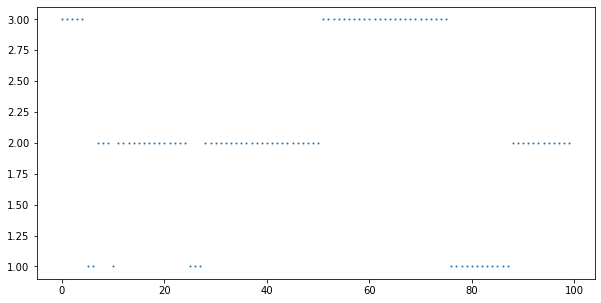

In [11]:
stages=y[n_epochs:n_epochs+100]
time = range(len(stages))
plt.gcf().set_size_inches(*(10,5))
plt.scatter(time, stages, s=1)

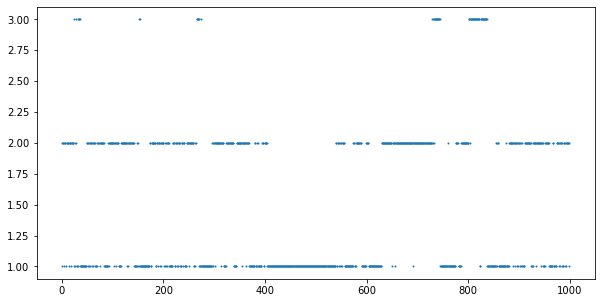

In [15]:
stages_pred = y_train_pred[9000:10000]
time = range(len(stages_pred))
plt.gcf().set_size_inches(*(10,5))
plt.scatter(time, stages_pred, s=1)

In [12]:
pipe2 = Pipeline([('scaling',StandardScaler()),
                 ('classification', lgb.LGBMClassifier(class_weight = 'balanced'))])
pipe2.fit(X_train_split, y_train_split)
y_train_pred2 = pipe2.predict(X[2*n_epochs:])

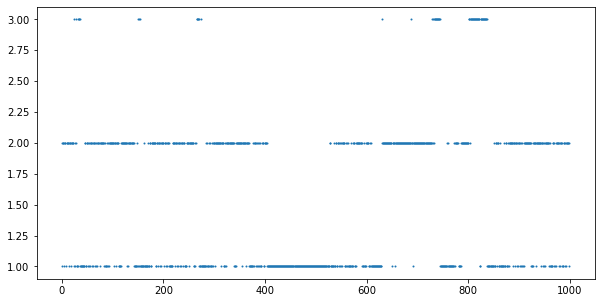

In [14]:
stages_pred2 = y_train_pred2[9000:10000]
time = range(len(stages_pred2))
plt.gcf().set_size_inches(*(10,5))
plt.scatter(time, stages_pred2, s=1)

In [24]:
X

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
0,-0.066646,-0.690627,0.485750,-0.197554,-0.321530,0.045072,-0.678207,1.381841,-0.233240,-0.939449,...,0.212532,-0.238351,-0.802309,0.802309,1.971968,-1.865146,-0.871820,-0.125381,-2.010804,2.010804
1,-0.648138,0.265557,0.699973,-0.197554,-0.321530,0.045072,0.130485,2.422138,1.034120,-0.063093,...,1.149181,-0.805549,-0.238795,0.238795,0.128515,-2.034068,1.645800,-1.186307,-0.356570,0.356570
2,-0.490831,-0.606445,0.415697,-0.197554,-0.136585,0.142109,0.174399,1.625248,2.405179,0.646058,...,1.001076,-0.505047,-0.375062,0.375062,1.206077,-1.342231,-0.413092,0.935544,-1.214057,1.214057
3,-0.369860,-0.938691,0.617876,-0.278489,-0.506474,0.077417,0.044916,1.589107,1.182479,0.261369,...,-0.604258,0.279663,-1.417694,1.417694,2.761541,-1.909184,-1.740949,-0.125381,-2.830885,2.830885
4,-0.994081,-0.398864,0.531921,-0.116618,-0.506474,0.045072,0.791554,3.374690,1.369616,-0.720281,...,-0.833770,-0.600788,-1.495602,1.495602,1.788389,-2.405526,-0.149813,-0.125381,-1.848910,1.848910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21595,0.513438,0.603925,-0.180089,0.297147,3.105516,0.042000,-0.227269,-1.331266,-1.337540,-0.340679,...,0.133635,-0.153358,0.398349,-0.398349,0.691443,0.865870,-1.619834,0.838616,-0.358980,0.358980
21596,0.907318,0.592089,-0.445869,-0.113248,0.020262,0.090191,0.007949,-1.084867,-1.088232,-0.550730,...,0.557643,0.896786,0.538996,-0.538996,-1.551074,0.448294,1.343886,-0.183329,1.164834,-1.164834
21597,0.974873,0.847782,0.634137,0.297147,0.923263,-0.006191,-0.676312,-1.189857,-1.334709,-0.372737,...,1.704545,0.896786,0.519292,-0.519292,0.218337,0.504081,-0.776997,-0.183329,0.057197,-0.057197
21598,1.283273,0.862702,-0.289594,-0.113248,-0.130238,0.042000,-0.829319,-1.105023,-1.347927,0.180751,...,1.926877,0.896786,0.198783,-0.198783,-0.724478,0.315440,0.480710,-1.205273,0.741029,-0.741029


In [39]:
# tuning:
lr = [0.05, 0.1]
iterations = [100, 300]
max_bin  = [255, 510]
num_leaves = [31, 51, 71]
parameters = [{'classification__learning_rate': lr, 
              'classification__num_iterations': iterations}]

In [36]:
pipe = Pipeline([('PCA', PCA(n_components=90)),
                 ('neighbour_features', nf.Neighbour_Features(lag=10)),
                 ('classification',lgb.LGBMClassifier(class_weight = 'balanced'))])

In [37]:
n_epochs = 21600
splits = [(np.r_[0:2*n_epochs], np.r_[2*n_epochs:3*n_epochs]),
 (np.r_[0:n_epochs, 2*n_epochs:3*n_epochs], np.r_[n_epochs:2*n_epochs]),
 (np.r_[n_epochs:3*n_epochs], np.r_[0:n_epochs])]

In [ ]:
clf = GridSearchCV(pipe, parameters,cv=splits,n_jobs=1,scoring='balanced_accuracy', verbose=10)
clf.fit(X, y)
print(clf.best_params_)
print(clf.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] classification__learning_rate=0.05, classification__num_iterations=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  classification__learning_rate=0.05, classification__num_iterations=100, score=0.962, total=  39.0s
[CV] classification__learning_rate=0.05, classification__num_iterations=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.0s remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  classification__learning_rate=0.05, classification__num_iterations=100, score=0.964, total=  38.1s
[CV] classification__learning_rate=0.05, classification__num_iterations=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  classification__learning_rate=0.05, classification__num_iterations=100, score=0.876, total=  37.3s
[CV] classification__learning_rate=0.05, classification__num_iterations=300 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.9min remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  classification__learning_rate=0.05, classification__num_iterations=300, score=0.962, total= 1.6min
[CV] classification__learning_rate=0.05, classification__num_iterations=300 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.5min remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  classification__learning_rate=0.05, classification__num_iterations=300, score=0.962, total= 1.6min
[CV] classification__learning_rate=0.05, classification__num_iterations=300 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  classification__learning_rate=0.05, classification__num_iterations=300, score=0.875, total= 1.6min
[CV] classification__learning_rate=0.1, classification__num_iterations=100 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.7min remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  classification__learning_rate=0.1, classification__num_iterations=100, score=0.962, total=  39.2s
[CV] classification__learning_rate=0.1, classification__num_iterations=100 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  7.4min remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  classification__learning_rate=0.1, classification__num_iterations=100, score=0.964, total=  40.0s
[CV] classification__learning_rate=0.1, classification__num_iterations=100 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  8.1min remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  classification__learning_rate=0.1, classification__num_iterations=100, score=0.876, total=  42.0s
[CV] classification__learning_rate=0.1, classification__num_iterations=300 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  8.8min remaining:    0.0s
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
